# Efficient Frontier

The following code calculates an Efficient Frontier for up to six assets. The user can choose which assets they would like to incorporate into their portfolio. Options include: S&P 500, Fixed Income, Gold, Private Credit, Real Estate, and Private Equity. The user can also select the time frame of the historical data used in the calculation.

In [83]:
import cvxpy as cp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [84]:
dropped_assets_string = input("Input the assets you would like to drop.\nMake sure to spell the assets correctly and separate each with a comma and a space.\nIf you do not want to drop any assets, simply press enter: ")

In [85]:
dropped_assets = dropped_assets_string.split(", ")
dropped_assets

['Fixed Income', 'Private Equity', 'Private Credit', 'Real Estate']

In [86]:
time_frame = input("Choose your desired time frame in years (1-10): ")

In [87]:
#Read in Data
asset_data = pd.read_csv("EF_Data_Summary.csv")
asset_data

,Month,S&P 500,Fixed Income,Gold,Private Credit,Real Estate,Private Equity
0,1/30/15,1994.99,1955.02,1283.79,933.11,317.41,1744.85
1,2/27/15,2104.50,1936.64,1213.18,987.22,308.89,1903.96
2,3/31/15,2067.89,1945.63,1183.57,979.69,310.75,1854.04
3,4/30/15,2085.51,1938.65,1184.37,989.70,295.33,1890.64
4,5/29/15,2107.39,1933.98,1190.58,989.64,293.95,1925.25
...,...,...,...,...,...,...,...
115,8/30/24,5648.40,2228.33,2503.39,1466.30,380.90,5001.46
116,9/30/24,5762.48,2258.17,2634.58,1468.34,391.07,5150.10
117,10/31/24,5705.45,2202.17,2743.97,1457.96,376.82,5038.92
118,11/29/24,6032.38,2225.45,2643.15,1504.10,391.66,5458.17


In [88]:
#drop rows of assets user does not want
if dropped_assets_string:
    asset_data = asset_data.drop(dropped_assets, axis=1)
asset_data

,Month,S&P 500,Gold
0,1/30/15,1994.99,1283.79
1,2/27/15,2104.50,1213.18
2,3/31/15,2067.89,1183.57
3,4/30/15,2085.51,1184.37
4,5/29/15,2107.39,1190.58
...,...,...,...
115,8/30/24,5648.40,2503.39
116,9/30/24,5762.48,2634.58
117,10/31/24,5705.45,2743.97
118,11/29/24,6032.38,2643.15


In [89]:
#Create variable used to filter to desired time frame
included_rows = int(time_frame)*12+1
included_rows

121

In [90]:
#Filter to the desired time frame
asset_data = asset_data.tail(included_rows)
asset_data

,Month,S&P 500,Gold
0,1/30/15,1994.99,1283.79
1,2/27/15,2104.50,1213.18
2,3/31/15,2067.89,1183.57
3,4/30/15,2085.51,1184.37
4,5/29/15,2107.39,1190.58
...,...,...,...
115,8/30/24,5648.40,2503.39
116,9/30/24,5762.48,2634.58
117,10/31/24,5705.45,2743.97
118,11/29/24,6032.38,2643.15


In [91]:
#Convert users' selected assets into a list for later use
selected_assets = asset_data.columns.tolist()
#take out Month
selected_assets = [col for col in selected_assets if col != 'Month']
# add "Weight" for later use
selected_assets = [col + ' Weight' for col in selected_assets]
selected_assets

['S&P 500 Weight', 'Gold Weight']

In [92]:
#Add "monthly return" to all columns besides Month
asset_data.columns = [col + " Monthly Return" if col != "Month" else col for col in asset_data.columns]

# Make every value a pct change except for the 'Month' column
asset_data.loc[:, asset_data.columns != "Month"] = asset_data.loc[:, asset_data.columns != "Month"].pct_change()
asset_data

,Month,S&P 500 Monthly Return,Gold Monthly Return
0,1/30/15,NaN,NaN
1,2/27/15,0.054893,-0.055001
2,3/31/15,-0.017396,-0.024407
3,4/30/15,0.008521,0.000676
4,5/29/15,0.010491,0.005243
...,...,...,...
115,8/30/24,0.022835,0.022794
116,9/30/24,0.020197,0.052405
117,10/31/24,-0.009897,0.041521
118,11/29/24,0.057301,-0.036742


In [93]:
#Remove unwanted data and drop first row
asset_data_returns = asset_data.loc[:, asset_data.columns.str.contains("Return")]
asset_data_returns = asset_data_returns.dropna()
asset_data_returns                                                         

,S&P 500 Monthly Return,Gold Monthly Return
1,0.054893,-0.055001
2,-0.017396,-0.024407
3,0.008521,0.000676
4,0.010491,0.005243
5,-0.021012,-0.015312
...,...,...
115,0.022835,0.022794
116,0.020197,0.052405
117,-0.009897,0.041521
118,0.057301,-0.036742


In [94]:
#Calculate Avg Monthly Returns and Annualize it (this one is arithmentic)
expected_returns = asset_data_returns.mean() * 12
expected_returns

S&P 500 Monthly Return    0.121258
Gold Monthly Return       0.081633
dtype: float64

In [95]:
#Calculate Covariance Matrix and Annualize it
cov_matrix = asset_data_returns.cov() * 12
cov_matrix

,S&P 500 Monthly Return,Gold Monthly Return
S&P 500 Monthly Return,0.023562,0.002239
Gold Monthly Return,0.002239,0.019038


In [96]:
#Primary Calculations
n = len(cov_matrix)
weights = cp.Variable(n)
weights

Variable((2,), var1645)

In [97]:
#Calculate Target Returns
target_returns = np.linspace(
expected_returns.min(),
expected_returns.max(),
10 # Number of points on the frontier
)
target_returns

array([0.08163293, 0.08603568, 0.09043843, 0.09484118, 0.09924393,
       0.10364669, 0.10804944, 0.11245219, 0.11685494, 0.12125769])

In [98]:
# Store results
efficient_portfolios = []
for target_return in target_returns:
    # Objective: Minimize portfolio variance
    portfolio_variance = cp.quad_form(weights, cov_matrix)
    objective = cp.Minimize(portfolio_variance)
    # Constraints
    constraints = [
        weights >= 0, # No short-selling
        cp.sum(weights) == 1, # Fully invested
        expected_returns.values @ weights >= target_return # Target return
        ]
    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve()
    if prob.status == 'optimal':
        annualized_return = expected_returns.values @ weights.value
        annualized_variance = portfolio_variance.value
        efficient_portfolios.append({
            'Weights': weights.value,
            'Return': annualized_return,
            'Variance': annualized_variance
            })

In [99]:
# Convert to DataFrame
efficient_frontier = pd.DataFrame(efficient_portfolios)
efficient_frontier['Standard Deviation'] = np.sqrt(efficient_frontier['Variance'])
# Remove duplicates (if any)
efficient_frontier = efficient_frontier.drop_duplicates(['Return', 'Variance'])
efficient_frontier

,Weights,Return,Variance,Standard Deviation
0,"[0.44065929929796266, 0.5593407007020373]",0.099094,0.011635,0.107866
4,"[0.44444444444444375, 0.5555555555555564]",0.099244,0.011636,0.107869
5,"[0.5555555555555547, 0.4444444444444453]",0.103647,0.012138,0.110175
6,"[0.6666666666666662, 0.33333333333333376]",0.108049,0.013582,0.116544
7,"[0.777777777777777, 0.222222222222223]",0.112452,0.015968,0.126364
8,"[0.8888888888888882, 0.11111111111111183]",0.116855,0.019294,0.138904
9,"[1.000000000054869, 1.6173165075262716e-09]",0.121258,0.023562,0.153500


In [100]:
# Split the 'Weights' into independent columns
efficient_frontier[selected_assets] = pd.DataFrame(efficient_frontier['Weights'].tolist(), index=efficient_frontier.index)

# Convert weights to percentages
efficient_frontier = efficient_frontier * 100

# Add '%' to the asset column names
efficient_frontier.columns = [f"{col} (%)" if 'Weight' in col else col for col in efficient_frontier.columns]

# Round the values to 2 decimal places
efficient_frontier = efficient_frontier.round(2)

# Change the index to 'Portfolio X' format
efficient_frontier.index = [f"Portfolio {i+1}" for i in range(len(efficient_frontier))]

# Rename columns
efficient_frontier = efficient_frontier.rename(columns={'Return': 'Expected Return (%)', 
                                                       'Variance': 'Variance (%)', 
                                                       'Standard Deviation': 'Standard Deviation (%)'})
#Drop Weights columns
efficient_frontier = efficient_frontier.drop("Weights (%)", axis=1)

#Drop Var Column
efficient_frontier = efficient_frontier.drop("Variance (%)", axis=1)
efficient_frontier

,Expected Return (%),Standard Deviation (%),S&P 500 Weight (%),Gold Weight (%)
Portfolio 1,9.91,10.79,44.07,55.93
Portfolio 2,9.92,10.79,44.44,55.56
Portfolio 3,10.36,11.02,55.56,44.44
Portfolio 4,10.80,11.65,66.67,33.33
Portfolio 5,11.25,12.64,77.78,22.22
Portfolio 6,11.69,13.89,88.89,11.11
Portfolio 7,12.13,15.35,100.00,0.00


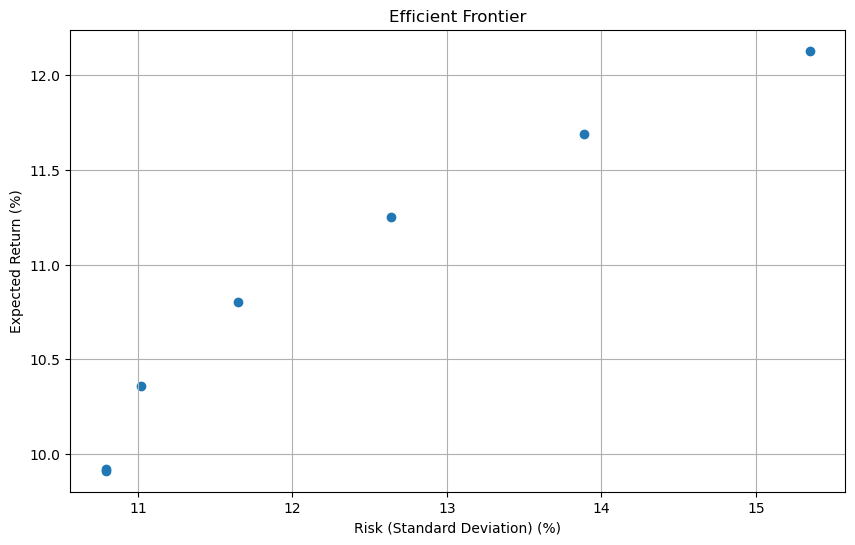

In [101]:
#Graph
plt.figure(figsize=(10, 6))
plt.scatter(
    efficient_frontier['Standard Deviation (%)'],
    efficient_frontier['Expected Return (%)'],
    marker='o'
)
plt.title('Efficient Frontier')
plt.xlabel('Risk (Standard Deviation) (%)')
plt.ylabel('Expected Return (%)')
plt.grid(True)
plt.show()